## Anomaly Detection for NYC Taxi & Limousine Data

In [98]:
import numpy as np
import pandas as pd
import os
import subprocess
from shapely.geometry import Point
from datetime import datetime
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as rs
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from itertools import compress

np.random.seed(222)

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
proj_folder = os.getcwd()

## TLC anomaly detection

In [119]:
### read in data for 2016
columns = ['passenger_count', 'trip_distance', 'fare_amount', \
                     'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime']
tlc_df_raw_total = pd.DataFrame(columns = columns)
for i in range(1,4):
    tlc_df_raw = pd.read_csv(proj_folder + '/data/tlc_yellow_2016_' + str(i) + '.csv', usecols=['passenger_count', \
                    'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'total_amount', \
                     'tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    tlc_df_raw_total = tlc_df_raw_total.append(tlc_df_raw, ignore_index=True)

In [120]:
len(tlc_df_raw_total)

34499859

In [121]:
tlc_df_raw_total['tpep_pickup_datetime'] = pd.to_datetime(tlc_df_raw_total['tpep_pickup_datetime'])
tlc_df_raw_total['tpep_dropoff_datetime'] = pd.to_datetime(tlc_df_raw_total['tpep_dropoff_datetime'])
tlc_df_raw_total.head()

,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
0,0.5,7.5,0.5,2.0,0.0,8.8,2016-01-01,2016-01-01,1.10
1,0.5,18.0,0.5,5.0,0.0,19.3,2016-01-01,2016-01-01,4.90
2,0.5,33.0,0.5,1.0,0.0,34.3,2016-01-01,2016-01-01,10.54
3,0.0,16.5,0.5,1.0,0.0,17.3,2016-01-01,2016-01-01,4.75
4,0.0,8.0,0.5,3.0,0.0,8.8,2016-01-01,2016-01-01,1.76


In [122]:
#CANNOT GET THIS TRIP DURATION TO WORK - MOVING ON FOR NOW
#tlc_df['trip_duration'] = pd.Timedelta(tlc_df['tpep_dropoff_datetime_2'] - tlc_df['tpep_pickup_datetime']).seconds / 3600.0
#tlc_df['trip_speed'] = tlc_df.trip_distance / tlc_df.trip_duration

In [123]:
#count the number of taxi trips each day
tlc_df_raw_total['taxi_date'] = tlc_df_raw_total['tpep_pickup_datetime'].dt.date
tlc_df_day_count = tlc_df_raw_total.groupby(['taxi_date'], as_index=False)['extra'].count()
tlc_df_day_count.columns = ['taxi_date', 'taxi_trip_count']

In [134]:
#take the mean of the taxi stats each day
tlc_df_stat_agg = tlc_df_raw_total.groupby(['taxi_date'], as_index=False).mean()
tlc_df_stat_agg.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance
0,2016-01-01,0.269715,12.856933,0.496751,1.792785,1.451324,15.640110,3.270908
1,2016-01-02,0.197588,12.434471,0.497473,1.776272,1.465769,15.189766,3.065510
2,2016-01-03,0.199482,13.061590,0.496981,1.737195,1.663452,16.098867,3.405868
3,2016-01-04,0.373599,12.207293,0.497722,1.647561,1.640299,15.366877,30.318864
4,2016-01-05,0.355729,12.001867,0.497956,1.634603,1.657823,15.094682,7.723013


In [135]:
tlc_df_by_day = tlc_df_stat_agg.merge(tlc_df_day_count, on='taxi_date')
tlc_df_by_day.head()

,taxi_date,extra,fare_amount,mta_tax,passenger_count,tip_amount,total_amount,trip_distance,taxi_trip_count
0,2016-01-01,0.269715,12.856933,0.496751,1.792785,1.451324,15.640110,3.270908,345037
1,2016-01-02,0.197588,12.434471,0.497473,1.776272,1.465769,15.189766,3.065510,312831
2,2016-01-03,0.199482,13.061590,0.496981,1.737195,1.663452,16.098867,3.405868,302878
3,2016-01-04,0.373599,12.207293,0.497722,1.647561,1.640299,15.366877,30.318864,316171
4,2016-01-05,0.355729,12.001867,0.497956,1.634603,1.657823,15.094682,7.723013,343251


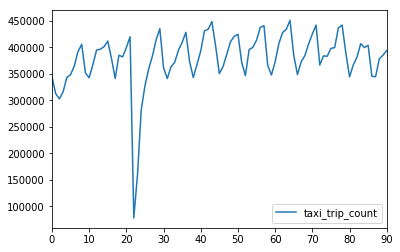

In [136]:
tlc_df_by_day[['taxi_date', 'taxi_trip_count']].plot()

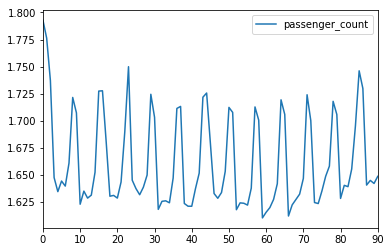

In [137]:
tlc_df_by_day[['taxi_date', 'passenger_count']].plot()

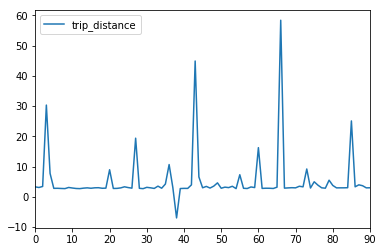

In [138]:
tlc_df_by_day[['taxi_date', 'trip_distance']].plot()

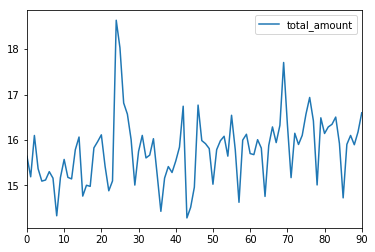

In [139]:
tlc_df_by_day[['taxi_date', 'total_amount']].plot()

In [140]:
X = tlc_df_by_day[['passenger_count', 'trip_distance' ,'total_amount', 'taxi_trip_count']]
X.head(2)

,passenger_count,trip_distance,total_amount,taxi_trip_count
0,1.792785,3.270908,15.640110,345037
1,1.776272,3.065510,15.189766,312831


In [141]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.839865903942
For n_clusters =3, the average silhouette_score is :0.568310426276
For n_clusters =4, the average silhouette_score is :0.544694498201
For n_clusters =5, the average silhouette_score is :0.587013791759
For n_clusters =6, the average silhouette_score is :0.60624090945
For n_clusters =7, the average silhouette_score is :0.594485011867
For n_clusters =8, the average silhouette_score is :0.591241254976


In [142]:
GM=GaussianMixture(n_components=2, random_state=324)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=324, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

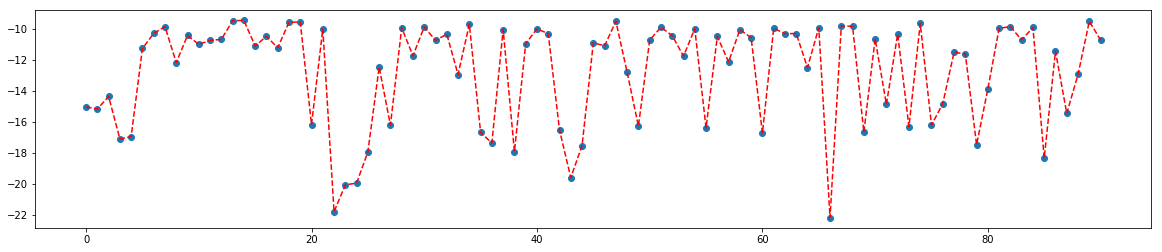

In [143]:
%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(X)),GM.score_samples(X))
plt.plot(GM.score_samples(X),"r--")
plt.show()